In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import concatenate,Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate,Dropout,Softmax,BatchNormalization,Activation,DepthwiseConv2D ,ReLU,Add,GlobalAveragePooling2D,Multiply,Average
from keras.optimizers import Adam
import keras.backend as K
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer,label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from keras.preprocessing import image
from keras.utils import load_img,img_to_array,array_to_img
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
import numpy as np
import cv2
import seaborn as sns
import keras
import matplotlib.cm as cm
import gc
from numba import cuda
from itertools import cycle
from keras.applications import VGG16, MobileNet, ResNet50

# Data Splitting and Preprocessing

In [2]:
dataset_path = r'C:\Users\Jin Zichao\Desktop\MV\rice-image\Rice_Image_Dataset'

images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

images_array = np.array(images)
labels_array = np.array(labels)

In [3]:
# Split the dataset as train:val:test = 70:15:15
x_train, x_other, y_train, y_other = train_test_split(images_array, labels_array, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_other, y_other, test_size=0.5, random_state=42)

df_train = pd.DataFrame({'image': x_train, 'label': y_train})
df_val = pd.DataFrame({'image': x_val, 'label': y_val})
df_test = pd.DataFrame({'image': x_test, 'label': y_test})

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

In [4]:
input_shape=(50, 50, 3)
batch_size = 32
num_classes = 5

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


# Building Attention Mechanism

In [5]:
def channel_attention(input_tensor, reduction_ratio=8):
    channels = input_tensor.shape[-1]
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    fc1 = tf.keras.layers.Dense(channels // reduction_ratio)(avg_pool)
    relu = tf.keras.layers.ReLU()(fc1)
    fc2 = tf.keras.layers.Dense(channels)(relu)
    sigmoid = tf.keras.layers.Activation('sigmoid')(fc2)
    attention = tf.keras.layers.Reshape((1, 1, channels))(sigmoid)
    scaled_input = tf.math.multiply(input_tensor, attention)
    return scaled_input

def spatial_attention(input_tensor):
    avg_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_tensor)
    max_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_tensor)
    concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    attention = tf.keras.layers.Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    scaled_input = tf.math.multiply(input_tensor, attention)
    return scaled_input

# Building Inception Model with Attention Mechanism

In [6]:
def inception_block(x, filters):
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3)

    conv5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5)

    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    inception_block = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool])
    return inception_block

def inception_net(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(input_tensor)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception blocks
    x = inception_block(x, filters=[64, 128, 128, 32, 32, 32])
    x = inception_block(x, filters=[128, 192, 192, 64, 64, 64])
    
    # MaxPooling
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Attention layers
    attention = channel_attention(x)
    attention = spatial_attention(attention)
    attention_maps = tf.keras.layers.multiply([x, attention])
    concatenate_maps = Concatenate()([x, attention_maps])
    
    # Flatten and Fully Connected layers
    x = Flatten()(concatenate_maps)
    x = Dense(512, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)

    return model

In [7]:
model_1 = inception_net(input_shape, num_classes)

In [8]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 25, 64)   832         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 13, 13, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 13, 13, 128)  8320        ['max_pooling2d[0][0]']          
                                                                                              

                                                                                                  
 flatten (Flatten)              (None, 43904)        0           ['concatenate_3[0][0]']          
                                                                                                  
 dense_2 (Dense)                (None, 512)          22479360    ['flatten[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 5)            2565        ['dense_2[0][0]']                
                                                                                                  
Total params: 23,272,960
Trainable params: 23,272,960
Non-trainable params: 0
__________________________________________________________________________________________________


# Building Residual Network of ResNet with Attention Mechanism

In [9]:
def residual_block(x, filters, kernel_size=3, strides=1):
    # Shortcut connection
    shortcut = x

    # First convolutional layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Attention layers
    attention = channel_attention(x)
    attention = spatial_attention(attention)
    x = Multiply()([x, attention])
        
    # Element-wise addition
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def resnet(input_shape, num_classes, num_blocks=[2, 2, 2, 2]):
    input_tensor = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(64, (2, 2), strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual blocks
    for block_num in range(len(num_blocks)):
        filters = 64 * (2 ** block_num)
        for _ in range(num_blocks[block_num]):
            if block_num > 0 and _ == 0:
                # Downsample for the first block in each group (except the first group)
                x = residual_block(x, filters, strides=2)
            else:
                x = residual_block(x, filters)
    
    # Global average pooling and dense layer
    x = GlobalAveragePooling2D()(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)

    return model

In [10]:
model_2 = resnet(input_shape, num_classes)

In [11]:
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 25, 25, 64)   832         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 25, 25, 64)  256         ['conv2d_14[0][0]']              
 alization)                                                                                       
                                                                                                  
 re_lu_1 (ReLU)                 (None, 25, 25, 64)   0           ['batch_normalization[0][0]

 activation_2 (Activation)      (None, 64)           0           ['dense_7[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 1, 1, 64)     0           ['activation_2[0][0]']           
                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None, 25, 25, 64)  0           ['batch_normalization_4[0][0]',  
 )                                                                'reshape_2[0][0]']              
                                                                                                  
 lambda_4 (Lambda)              (None, 25, 25, 1)    0           ['tf.math.multiply_4[0][0]']     
                                                                                                  
 lambda_5 (Lambda)              (None, 25, 25, 1)    0           ['tf.math.multiply_4[0][0]']     
          

 batch_normalization_8 (BatchNo  (None, 13, 13, 128)  512        ['conv2d_25[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 re_lu_11 (ReLU)                (None, 13, 13, 128)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_26 (Conv2D)             (None, 13, 13, 128)  147584      ['re_lu_11[0][0]']               
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 13, 13, 128)  512        ['conv2d_26[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 global_av

 conv2d_31 (Conv2D)             (None, 7, 7, 1)      99          ['concatenate_8[0][0]']          
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 7, 7, 256)   0           ['tf.math.multiply_10[0][0]',    
 a)                                                               'conv2d_31[0][0]']              
                                                                                                  
 conv2d_30 (Conv2D)             (None, 7, 7, 256)    33024       ['re_lu_13[0][0]']               
                                                                                                  
 multiply_5 (Multiply)          (None, 7, 7, 256)    0           ['batch_normalization_11[0][0]', 
                                                                  'tf.math.multiply_11[0][0]']    
                                                                                                  
 batch_nor

                                                                 ]']                              
                                                                                                  
 re_lu_21 (ReLU)                (None, 64)           0           ['dense_16[0][0]']               
                                                                                                  
 dense_17 (Dense)               (None, 512)          33280       ['re_lu_21[0][0]']               
                                                                                                  
 activation_7 (Activation)      (None, 512)          0           ['dense_17[0][0]']               
                                                                                                  
 reshape_7 (Reshape)            (None, 1, 1, 512)    0           ['activation_7[0][0]']           
                                                                                                  
 tf.math.m

                                                                  're_lu_22[0][0]']               
                                                                                                  
 re_lu_25 (ReLU)                (None, 4, 4, 512)    0           ['add_7[0][0]']                  
                                                                                                  
 global_average_pooling2d_9 (Gl  (None, 512)         0           ['re_lu_25[0][0]']               
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_20 (Dense)               (None, 5)            2565        ['global_average_pooling2d_9[0][0
                                                                 ]']                              
                                                                                                  
Total para

# Combine the models into the Ensemble Model

In [12]:
# Define input tensor
input_tensor = Input(shape=input_shape)

# Feed input tensor to both models
output1 = model_1(input_tensor)
output2 = model_2(input_tensor)

# Concatenate the outputs of both models
concatenate_outputs = Concatenate()([output1, output2])

# Apply softmax to the concatenated outputs
ensemble_output = Dense(num_classes, activation='softmax')(concatenate_outputs)

# Create the ensemble model
ensemble_model = Model(inputs=input_tensor, outputs=ensemble_output)

In [13]:
# Display the ensemble model summary
ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 5)            23272960    ['input_3[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 5)            11361869    ['input_3[0][0]']                
                                                                                                  
 concatenate_12 (Concatenate)   (None, 10)           0           ['model[0][0]',                  
                                                                  'model_1[0][0]']          

# Building Pre-trained models for Fair Comparison

In [14]:
# Load pre-trained VGG16 model (excluding top layers)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
# Add custom top layers for classification
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
output = Dense(5, activation='softmax')(x)
# Create the new model
vgg = Model(inputs=base_model.input, outputs=output)
# Freeze base layers to prevent their weights from being updated
for layer in base_model.layers:
    layer.trainable = False
    
# Load pre-trained MobileNet model (excluding top layers)
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
# Add custom top layers for classification
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
output = Dense(5, activation='softmax')(x)
# Create the new model
mobilenet = Model(inputs=base_model.input, outputs=output)
# Freeze base layers to prevent their weights from being updated
for layer in base_model.layers:
    layer.trainable = False
    
# Load pre-trained ResNet50 model (excluding top layers)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
# Add custom top layers for classification
x = Flatten()(base_model.output)
x = Dense(64, activation='relu')(x)
output = Dense(5, activation='softmax')(x)
# Create the new model
resnet = Model(inputs=base_model.input, outputs=output)
# Freeze base layers to prevent their weights from being updated
for layer in base_model.layers:
    layer.trainable = False

# Compile and Train the Model

In [15]:
# Define the accuracy and loss functions
def my_accuracy(y_true, y_pred):
    pred_labels = tf.argmax(y_pred, axis=-1)
    true_labels = tf.argmax(y_true, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(pred_labels, true_labels), tf.float32))
    return accuracy

def my_loss(y_true, y_pred):
    square = tf.square(y_true - y_pred)
    loss = tf.reduce_mean(square)
    return loss

In [16]:
# Set the learning rate
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_steps = 4
    if epoch % decay_steps == 0 and epoch > 0:
        return lr * decay_rate
    return lr

lr_decay_callback = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=0.001)

In [17]:
# Compile the model
ensemble_model.compile(loss=my_loss, optimizer=optimizer, metrics=[my_accuracy])
vgg.compile(loss=my_loss, optimizer=optimizer, metrics=[my_accuracy])
mobilenet.compile(loss=my_loss, optimizer=optimizer, metrics=[my_accuracy])
resnet.compile(loss=my_loss, optimizer=optimizer, metrics=[my_accuracy])

In [18]:
histories = {}
histories['Ensemble Model'] = ensemble_model.fit(train_generator,epochs=10,batch_size=batch_size,validation_data=val_generator,callbacks=[lr_decay_callback])

Epoch 1/10
1641/1641 [==============================] - 165s 96ms/step - loss: 0.0577 - my_accuracy: 0.8428 - val_loss: 0.0986 - val_my_accuracy: 0.5455 - lr: 0.0010
Epoch 2/10
1641/1641 [==============================] - 155s 95ms/step - loss: 0.0177 - my_accuracy: 0.9488 - val_loss: 0.0841 - val_my_accuracy: 0.6122 - lr: 0.0010
Epoch 3/10
1641/1641 [==============================] - 158s 96ms/step - loss: 0.0117 - my_accuracy: 0.9654 - val_loss: 0.0357 - val_my_accuracy: 0.8522 - lr: 0.0010
Epoch 4/10
1641/1641 [==============================] - 159s 97ms/step - loss: 0.0087 - my_accuracy: 0.9733 - val_loss: 0.0065 - val_my_accuracy: 0.9804 - lr: 0.0010
Epoch 5/10
1641/1641 [==============================] - 155s 94ms/step - loss: 0.0034 - my_accuracy: 0.9904 - val_loss: 0.0027 - val_my_accuracy: 0.9921 - lr: 1.0000e-04
Epoch 6/10
1641/1641 [==============================] - 155s 94ms/step - loss: 0.0030 - my_accuracy: 0.9911 - val_loss: 0.0024 - val_my_accuracy: 0.9928 - lr: 1.0000e

In [19]:
K.clear_session()
gc.collect()
histories['VGG16'] = vgg.fit(train_generator,epochs=10,batch_size=batch_size,validation_data=val_generator)

Epoch 1/10
1641/1641 [==============================] - 85s 51ms/step - loss: 0.1275 - my_accuracy: 0.5763 - val_loss: 0.1076 - val_my_accuracy: 0.7063
Epoch 2/10
1641/1641 [==============================] - 78s 47ms/step - loss: 0.0969 - my_accuracy: 0.7346 - val_loss: 0.0869 - val_my_accuracy: 0.7640
Epoch 3/10
1641/1641 [==============================] - 78s 47ms/step - loss: 0.0818 - my_accuracy: 0.7762 - val_loss: 0.0767 - val_my_accuracy: 0.7934
Epoch 4/10
1641/1641 [==============================] - 77s 47ms/step - loss: 0.0731 - my_accuracy: 0.7963 - val_loss: 0.0692 - val_my_accuracy: 0.8074
Epoch 5/10
1641/1641 [==============================] - 79s 48ms/step - loss: 0.0674 - my_accuracy: 0.8073 - val_loss: 0.0637 - val_my_accuracy: 0.8148
Epoch 6/10
1641/1641 [==============================] - 76s 46ms/step - loss: 0.0626 - my_accuracy: 0.8164 - val_loss: 0.0594 - val_my_accuracy: 0.8250
Epoch 7/10
1641/1641 [==============================] - 77s 47ms/step - loss: 0.0592 - m

In [20]:
K.clear_session()
gc.collect()
histories['MobileNet'] = mobilenet.fit(train_generator,epochs=10,batch_size=batch_size,validation_data=val_generator)

Epoch 1/10
1641/1641 [==============================] - 79s 47ms/step - loss: 0.1556 - my_accuracy: 0.3638 - val_loss: 0.1517 - val_my_accuracy: 0.4100
Epoch 2/10
1641/1641 [==============================] - 73s 44ms/step - loss: 0.1488 - my_accuracy: 0.4152 - val_loss: 0.1458 - val_my_accuracy: 0.4236
Epoch 3/10
1641/1641 [==============================] - 76s 46ms/step - loss: 0.1435 - my_accuracy: 0.4273 - val_loss: 0.1411 - val_my_accuracy: 0.4372
Epoch 4/10
1641/1641 [==============================] - 79s 48ms/step - loss: 0.1396 - my_accuracy: 0.4354 - val_loss: 0.1379 - val_my_accuracy: 0.4424
Epoch 5/10
1641/1641 [==============================] - 76s 46ms/step - loss: 0.1366 - my_accuracy: 0.4411 - val_loss: 0.1349 - val_my_accuracy: 0.4492
Epoch 6/10
1641/1641 [==============================] - 76s 46ms/step - loss: 0.1343 - my_accuracy: 0.4431 - val_loss: 0.1329 - val_my_accuracy: 0.4499
Epoch 7/10
1641/1641 [==============================] - 74s 45ms/step - loss: 0.1323 - m

In [21]:
K.clear_session()
gc.collect()
histories['ResNet50'] = resnet.fit(train_generator,epochs=10,batch_size=batch_size,validation_data=val_generator)

Epoch 1/10
1641/1641 [==============================] - 84s 49ms/step - loss: 0.1383 - my_accuracy: 0.4815 - val_loss: 0.1271 - val_my_accuracy: 0.5390
Epoch 2/10
1641/1641 [==============================] - 75s 46ms/step - loss: 0.1213 - my_accuracy: 0.5632 - val_loss: 0.1154 - val_my_accuracy: 0.5855
Epoch 3/10
1641/1641 [==============================] - 77s 47ms/step - loss: 0.1121 - my_accuracy: 0.6054 - val_loss: 0.1070 - val_my_accuracy: 0.6359
Epoch 4/10
1641/1641 [==============================] - 78s 48ms/step - loss: 0.1052 - my_accuracy: 0.6436 - val_loss: 0.1019 - val_my_accuracy: 0.6709
Epoch 5/10
1641/1641 [==============================] - 78s 48ms/step - loss: 0.0998 - my_accuracy: 0.6694 - val_loss: 0.0963 - val_my_accuracy: 0.6805
Epoch 6/10
1641/1641 [==============================] - 77s 47ms/step - loss: 0.0949 - my_accuracy: 0.6908 - val_loss: 0.0918 - val_my_accuracy: 0.7037
Epoch 7/10
1641/1641 [==============================] - 73s 45ms/step - loss: 0.0910 - m

# Evaluate the Model

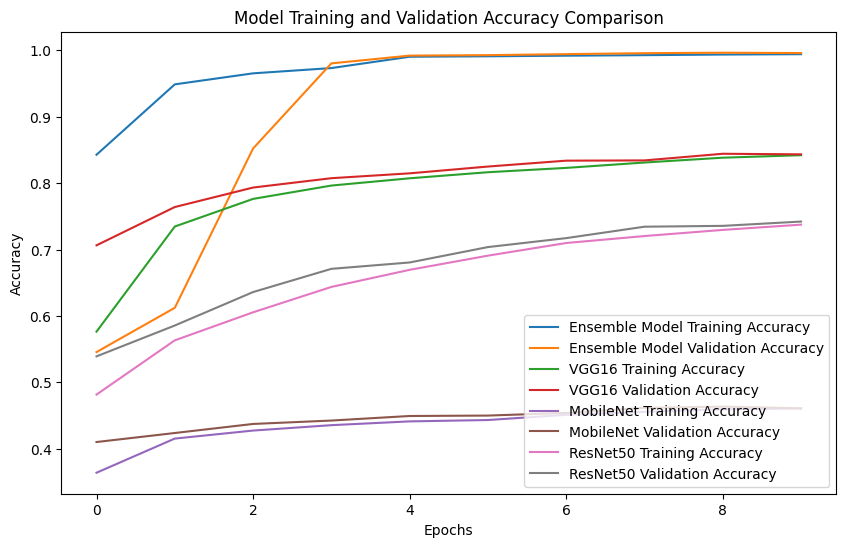

In [22]:
# Model Training and Validation Accuracy Comparison for Different Models
plt.figure(figsize=(10, 6))
for name, history in histories.items():
    plt.plot(history.history['my_accuracy'], label=f'{name} Training Accuracy')
    plt.plot(history.history['val_my_accuracy'], label=f'{name} Validation Accuracy')
plt.title('Model Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

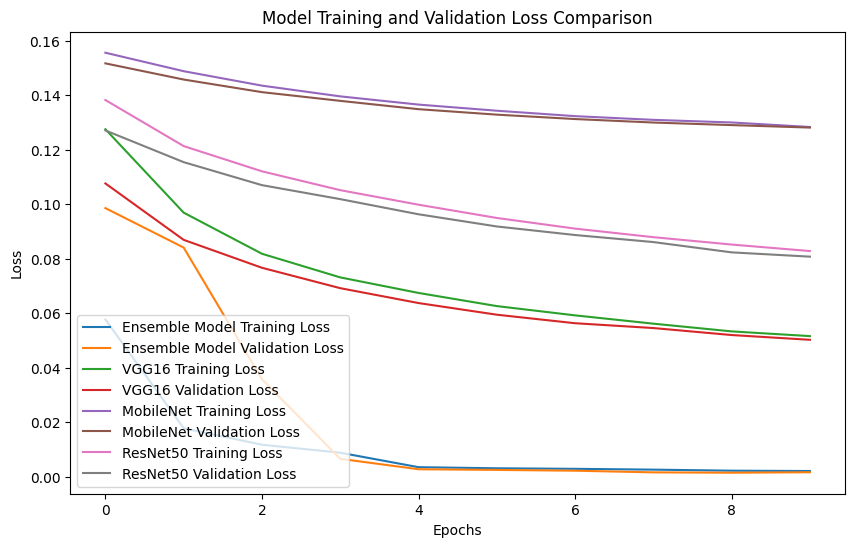

In [23]:
# Model Training and Validation Loss Comparison for Different Models
plt.figure(figsize=(10, 6))
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{name} Validation Loss')
plt.title('Model Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Evaluate the ensemble model on the test set
models = {'Ensemble Model':ensemble_model,'VGG16':vgg,'MobileNet':mobilenet,'ResNet50':resnet}
for name, model in models.items():
    i = 0
    print(name)
    test_loss_ensemble, test_acc_ensemble = model.evaluate(test_generator)
    print("Test Accuracy:", test_acc_ensemble)
    print("Test Loss:", test_loss_ensemble)
    i += 1

Ensemble Model
352/352 [==============================] - 19s 52ms/step - loss: 0.0020 - my_accuracy: 0.9942
Test Accuracy: 0.9942293763160706
Test Loss: 0.001961392117664218
VGG16
352/352 [==============================] - 14s 39ms/step - loss: 0.0511 - my_accuracy: 0.8390
Test Accuracy: 0.838975727558136
Test Loss: 0.05114879459142685
MobileNet
352/352 [==============================] - 15s 41ms/step - loss: 0.1275 - my_accuracy: 0.4643
Test Accuracy: 0.46429136395454407
Test Loss: 0.1275496929883957
ResNet50
352/352 [==============================] - 13s 37ms/step - loss: 0.0811 - my_accuracy: 0.7343
Test Accuracy: 0.7343355417251587
Test Loss: 0.08114233613014221


Ensemble Model


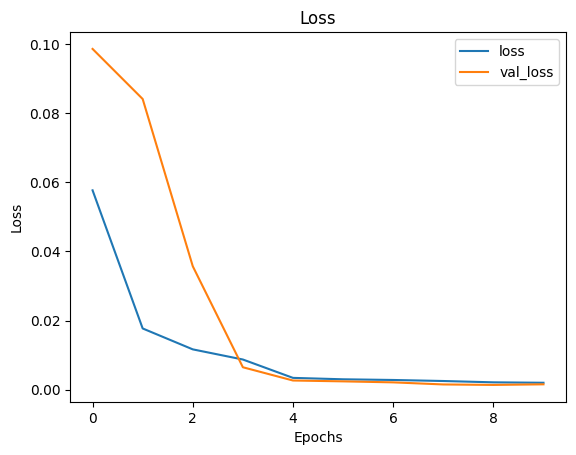

VGG16


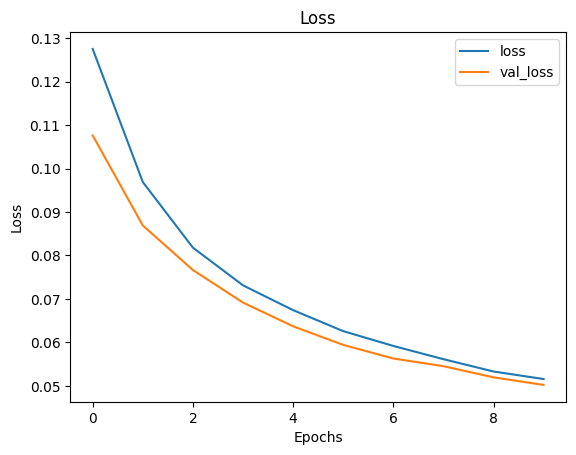

MobileNet


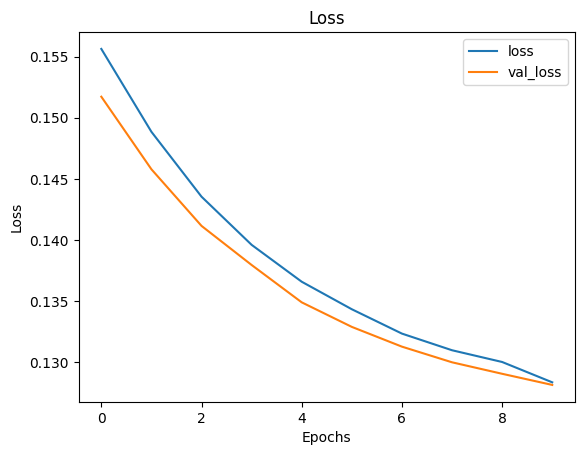

ResNet50


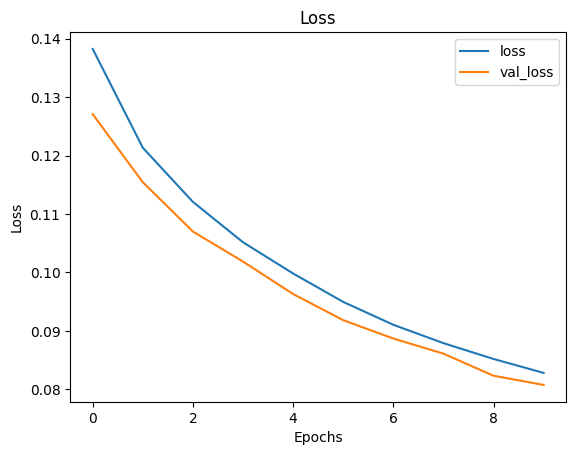

In [25]:
for name, history in histories.items():
    print(name)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

Ensemble Model


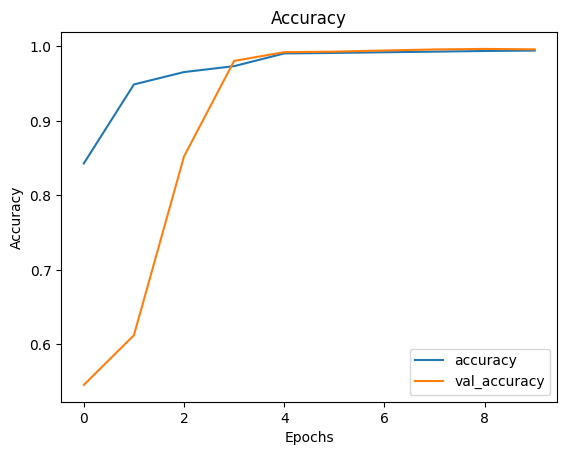

VGG16


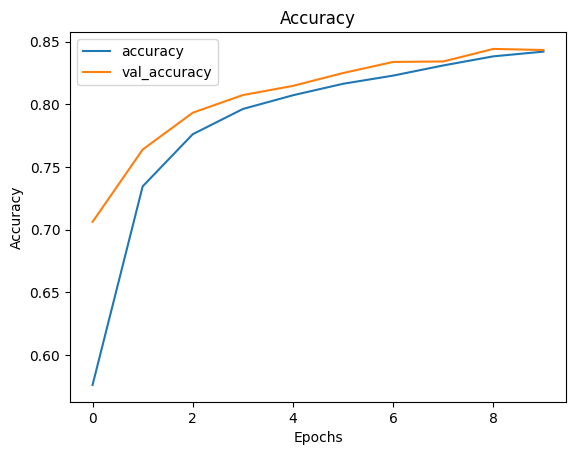

MobileNet


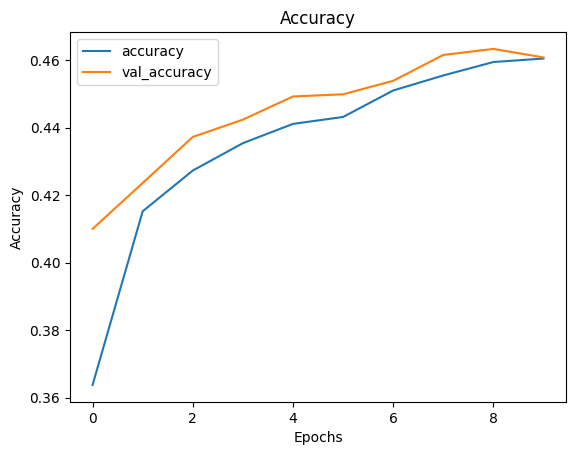

ResNet50


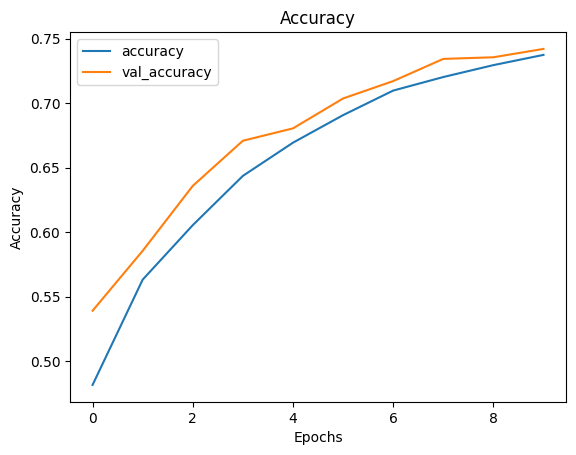

In [26]:
for name, history in histories.items():
    print(name)
    plt.plot(history.history['my_accuracy'], label='accuracy')
    plt.plot(history.history['val_my_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [27]:
y_true = test_generator.classes
rice_names = df_test["label"].unique()
for name, model in models.items():
    i = 0
    print(name)
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred,axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    print(classification_report(y_true, y_pred_classes, target_names=rice_names))
    i += 1

Ensemble Model
352/352 [==============================] - 13s 36ms/step
              precision    recall  f1-score   support

   Karacadag       0.99      0.99      0.99      2229
     Basmati       1.00      1.00      1.00      2227
      Ipsala       1.00      1.00      1.00      2368
     Arborio       0.99      0.99      0.99      2261
     Jasmine       1.00      1.00      1.00      2165

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250

VGG16
352/352 [==============================] - 13s 36ms/step
              precision    recall  f1-score   support

   Karacadag       0.77      0.77      0.77      2229
     Basmati       0.85      0.86      0.86      2227
      Ipsala       0.94      0.94      0.94      2368
     Arborio       0.81      0.79      0.80      2261
     Jasmine       0.83      0.83      0.83      2165

    accuracy                           0.84     11

Ensemble Model
352/352 [==============================] - 14s 39ms/step


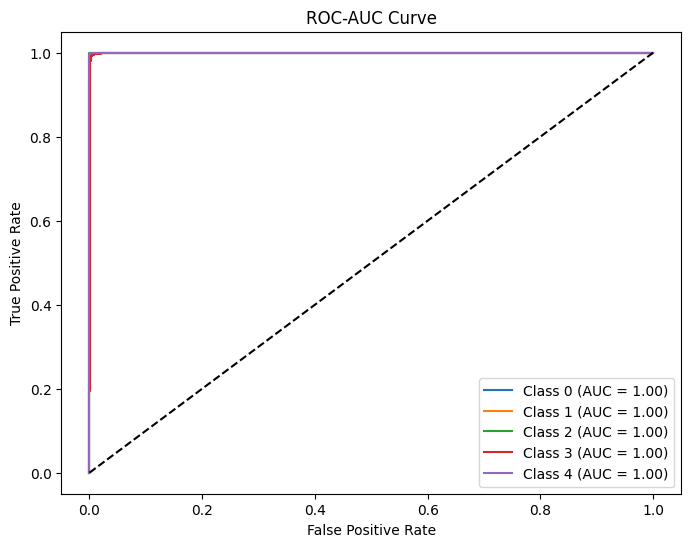

VGG16
352/352 [==============================] - 14s 38ms/step


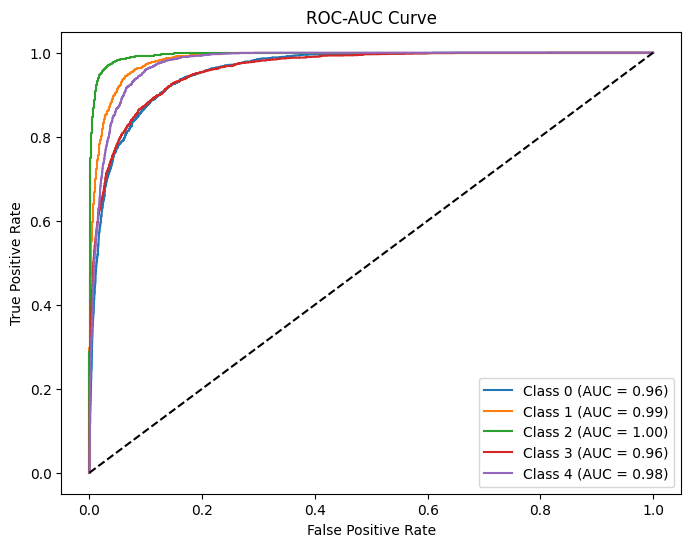

MobileNet
352/352 [==============================] - 13s 36ms/step


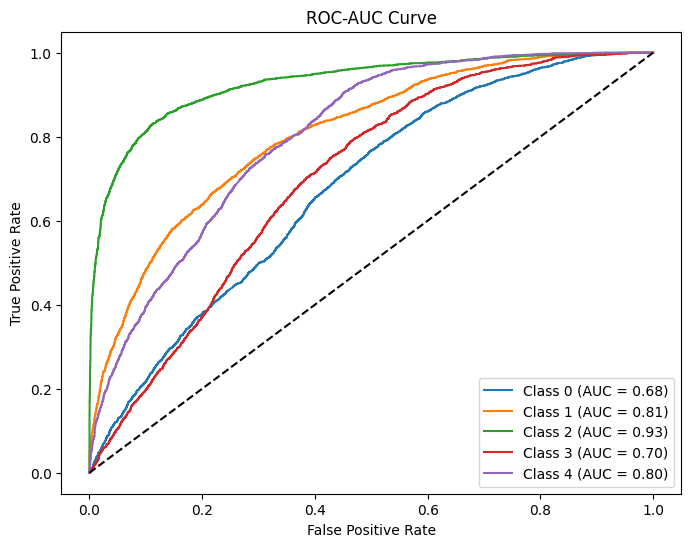

ResNet50
352/352 [==============================] - 15s 41ms/step


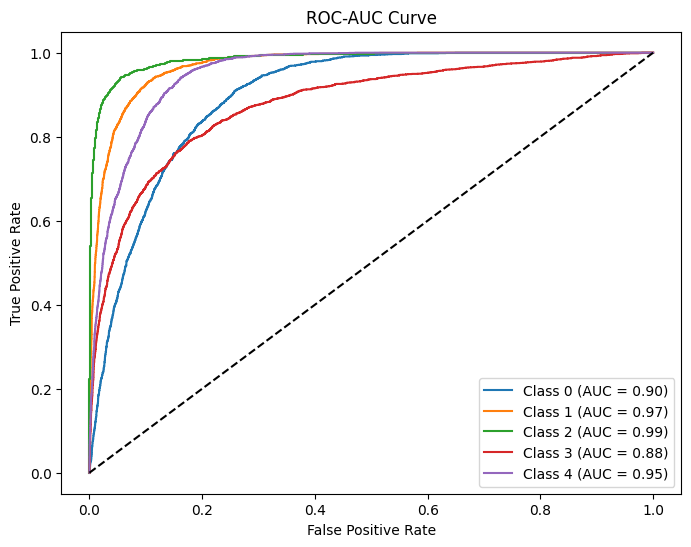

In [28]:
for name, model in models.items():
    i = 0
    print(name)
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred,axis=1)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_pred[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend()
    plt.show()
    i += 1

In [29]:
for name, model in models.items():
    i = 0
    print(name)
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred,axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    sensitivity_per_class = recall_score(y_true, y_pred_classes, average=None)
    specificity_per_class = []
    for i in range(cm.shape[0]):
        true_negatives = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        false_positives = np.sum(cm[:, i]) - cm[i, i]
        specificity_per_class.append(true_negatives / (true_negatives + false_positives))
    print("Sensitivity of Each Class:", sensitivity_per_class)
    print("Specificity of Each Class:", specificity_per_class)
    i += 1

Ensemble Model
352/352 [==============================] - 14s 40ms/step
Sensitivity of Each Class: [0.99237326 0.99595869 0.9995777  0.99026979 0.99769053]
Specificity of Each Class: [0.9970069837046891, 0.9998891721157043, 1.0, 0.997107575926132, 1.0]
VGG16
352/352 [==============================] - 13s 38ms/step
Sensitivity of Each Class: [0.77074921 0.87696453 0.93876689 0.78770456 0.84849885]
Specificity of Each Class: [0.9475667886043676, 0.9634267981824227, 0.9824363882008557, 0.9538324618978752, 0.9599339570720968]
MobileNet
352/352 [==============================] - 13s 38ms/step
Sensitivity of Each Class: [0.03185285 0.58015267 0.77618243 0.38876603 0.50623557]
Specificity of Each Class: [0.967741935483871, 0.8440651667959659, 0.9229903174960594, 0.7752808988764045, 0.8159603742432581]
ResNet50
352/352 [==============================] - 14s 39ms/step
Sensitivity of Each Class: [0.37236429 0.84104176 0.91173986 0.67271119 0.86974596]
Specificity of Each Class: [0.95721095222259

Ensemble Model
352/352 [==============================] - 13s 37ms/step


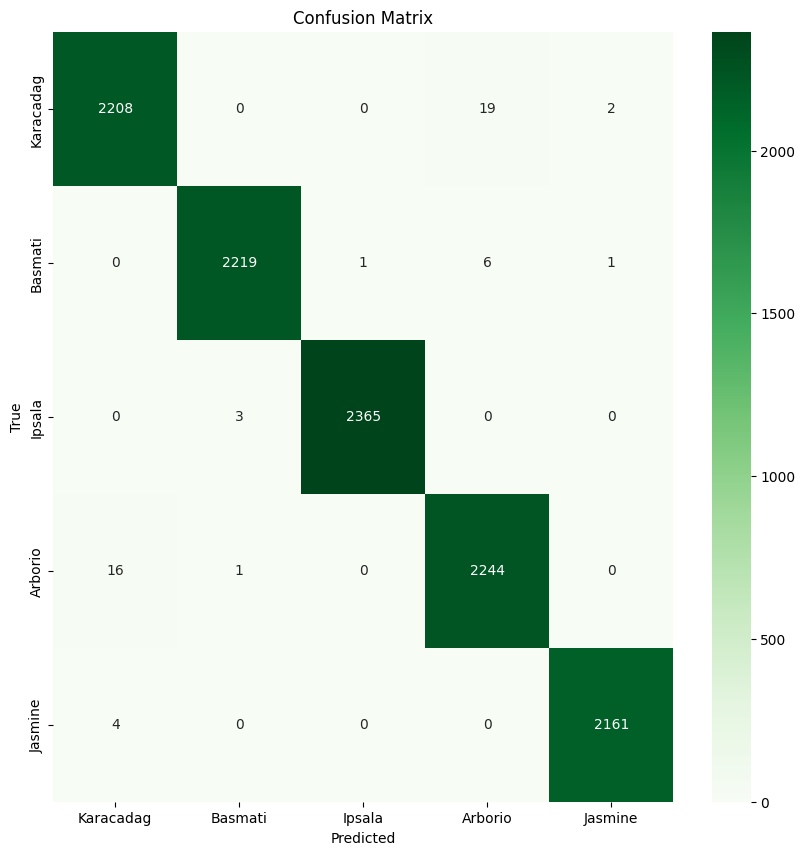

VGG16
352/352 [==============================] - 14s 40ms/step


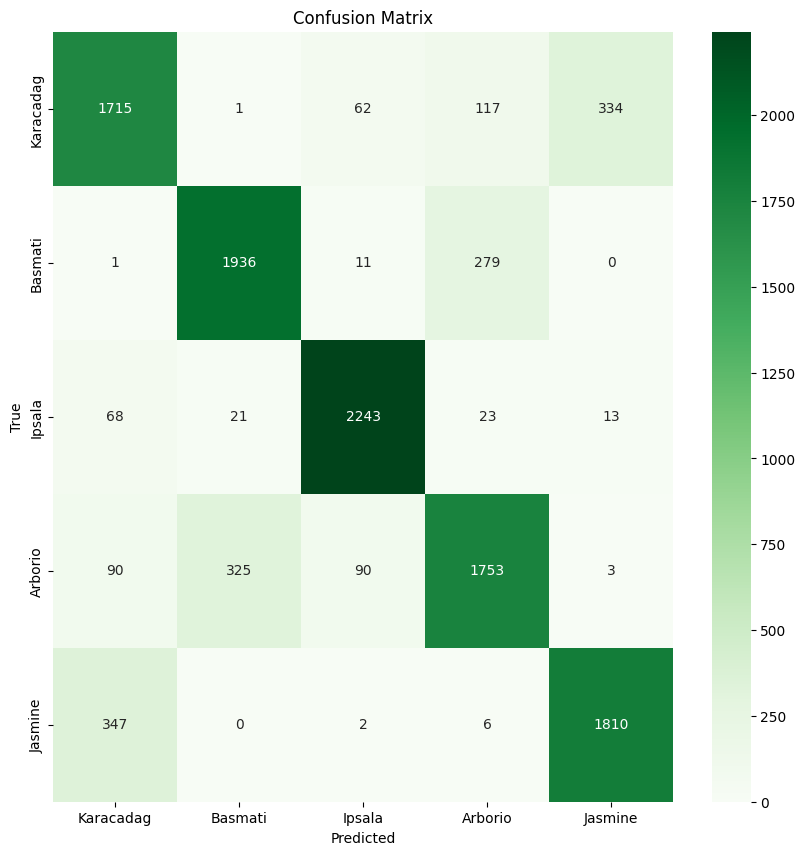

MobileNet
352/352 [==============================] - 14s 40ms/step


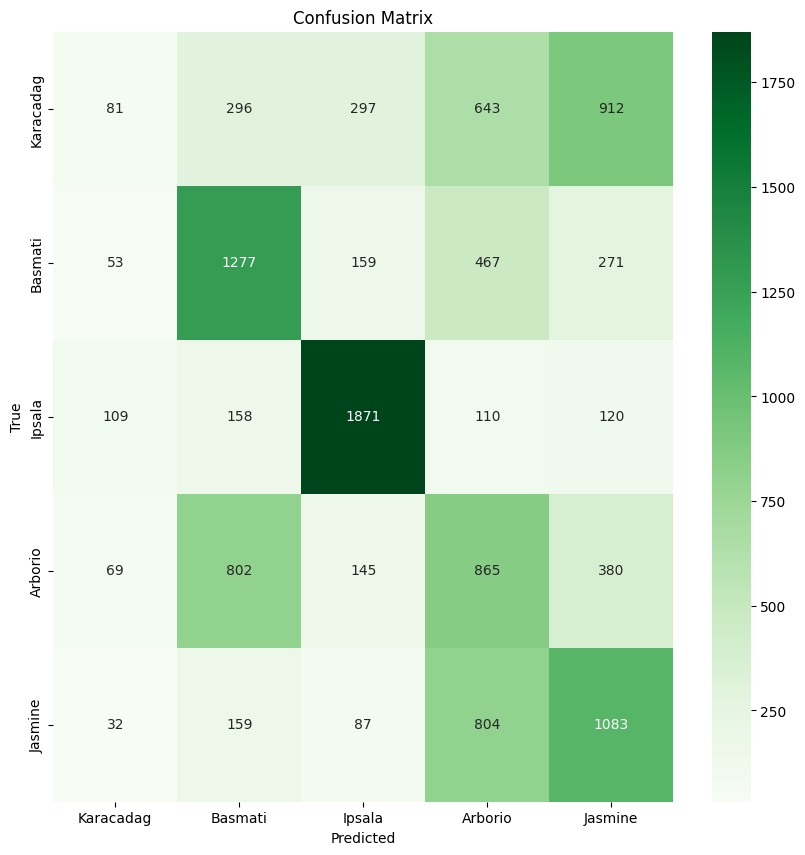

ResNet50
352/352 [==============================] - 15s 41ms/step


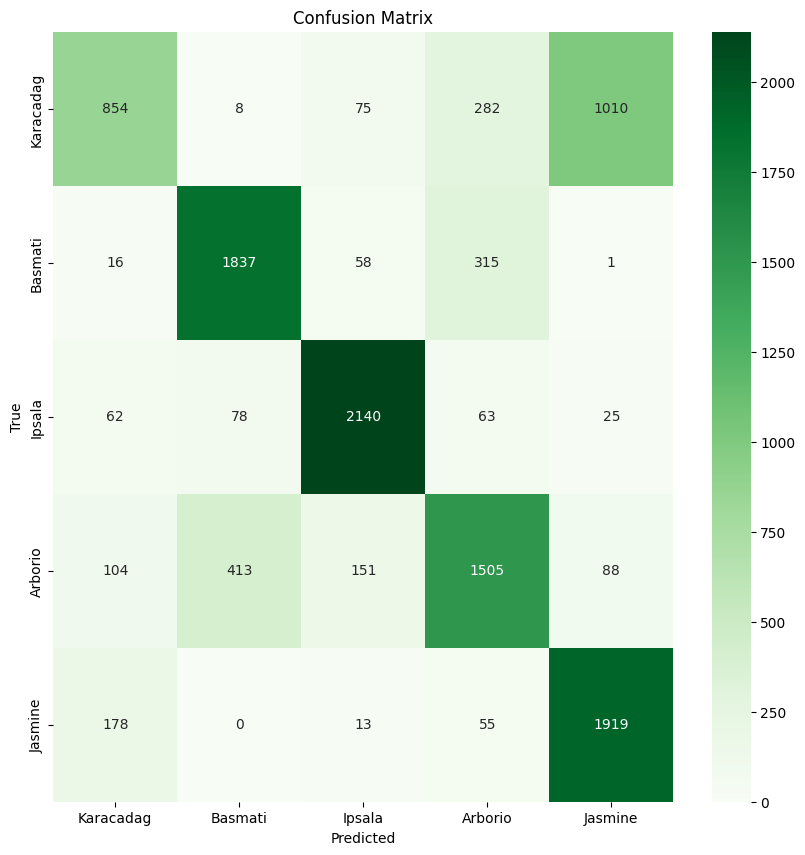

In [30]:
for name, model in models.items():
    i = 0
    print(name)
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred,axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    f,ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=rice_names, yticklabels=rice_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    i += 1

Ensemble Model
352/352 [==============================] - 15s 41ms/step


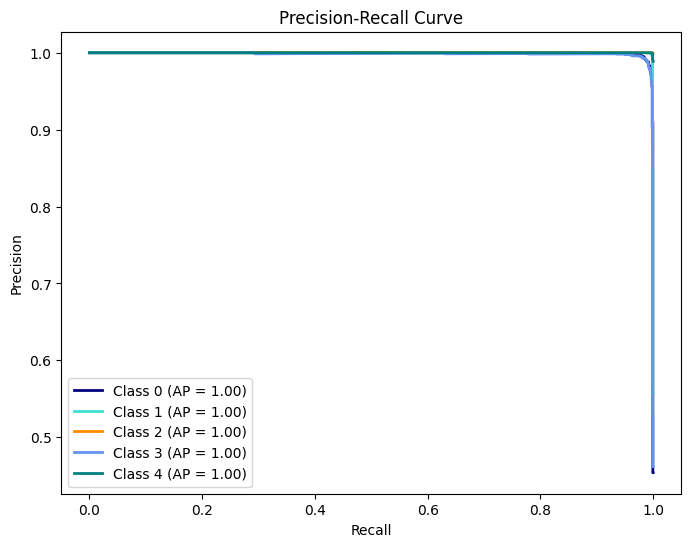

VGG16
352/352 [==============================] - 13s 38ms/step


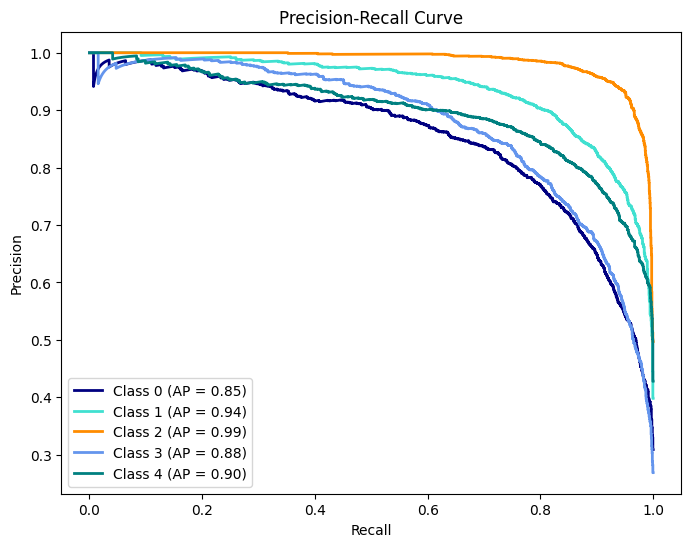

MobileNet
352/352 [==============================] - 14s 39ms/step


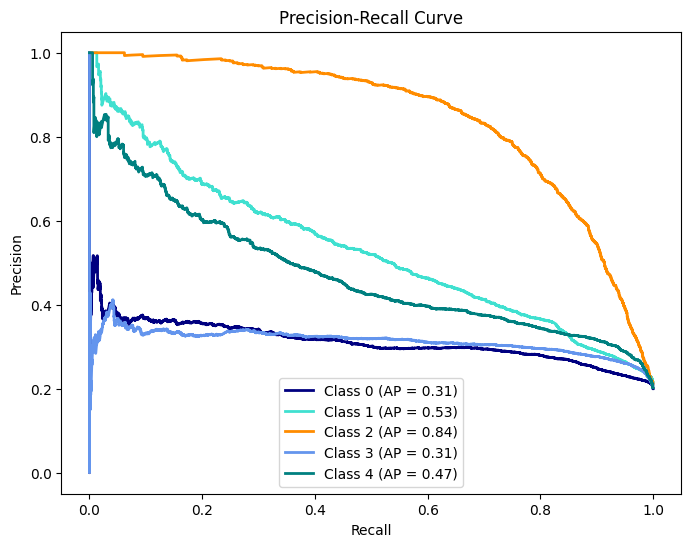

ResNet50
352/352 [==============================] - 14s 40ms/step


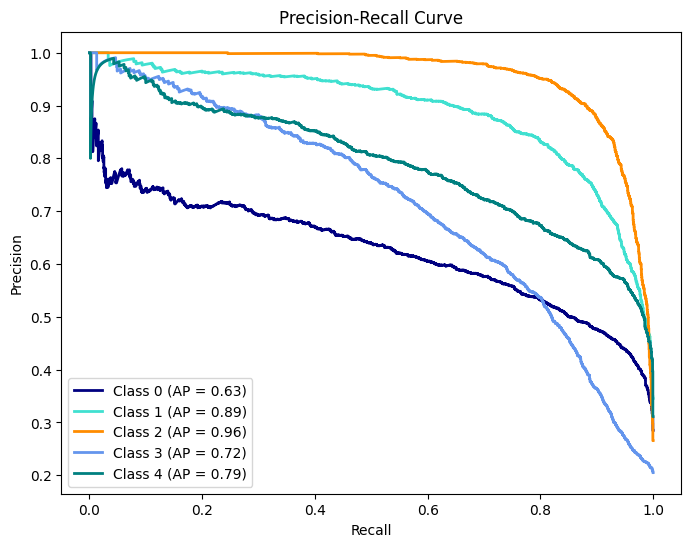

In [31]:
for name, model in models.items():
    i = 0
    print(name)
    y_pred = model.predict(test_generator)

    num_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

    precision = []
    recall = []
    average_precision = []

    for i in range(num_classes):
        precision_i, recall_i, _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
        average_precision_i = average_precision_score(y_test_bin[:, i], y_pred[:, i])
        precision.append(precision_i)
        recall.append(recall_i)
        average_precision.append(average_precision_i)

    plt.figure(figsize=(8, 6))
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Class {i} (AP = {average_precision[i]:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

In [32]:
K.clear_session()
gc.collect()

39414

In [33]:
cuda.select_device(0)
cuda.close()